In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('models')
from sim_cosmology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform2d import DWT
from utils import get_2dfilts
from wave_attributions import Attributer
from viz import cshow, plot_reconstruct, plot_filts

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)

# # check prediction
# with torch.no_grad():
#     result = {'y': [], 'pred': []}
#     for data, params in train_loader:
#         result['y'].append(params[:,1].detach().cpu())
#         result['pred'].append(model(data.to(device))[:,1].detach().cpu())
# plt.scatter(torch.cat(result['y']), torch.cat(result['pred']))
# plt.xlabel('true param')
# plt.ylabel('predicted param')
# plt.show()  

## initialize filter

In [23]:
# get image
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

# wavelet transform 
wt = DWT(wave='db3', mode='symmetric', J=3, init_factor=1, noise_factor=0.1).to(device)

im_t = wt(im)
recon = wt.inverse(im_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - im)**2/im.size(0)))

# get 2d wavelet filters
filt = get_2dfilts(wt)

Reconstruction error=95.19233


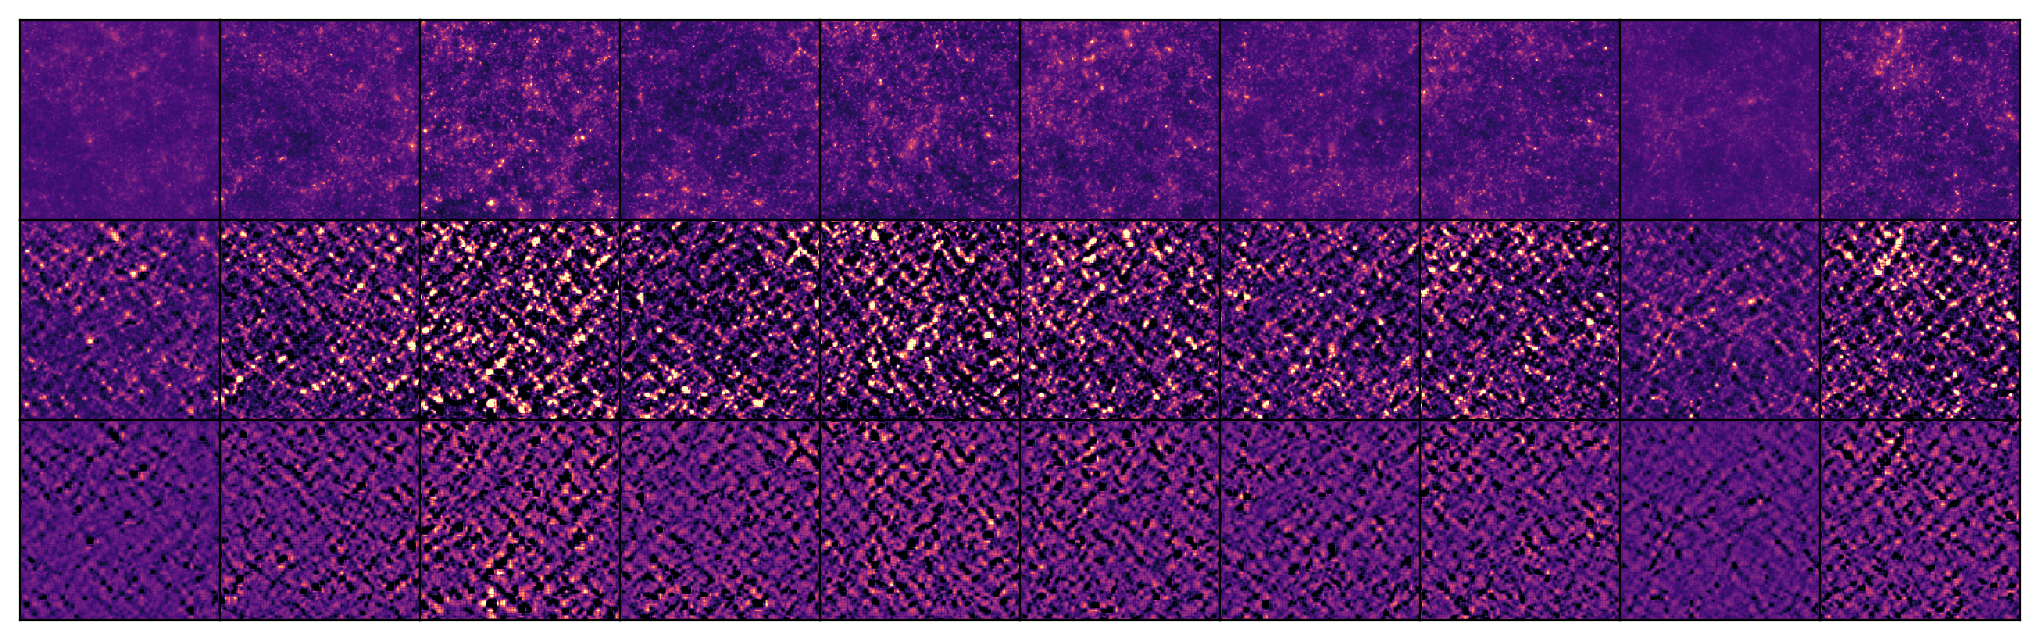

In [24]:
# plot original and reconstruction images
plot_reconstruct(im, recon)

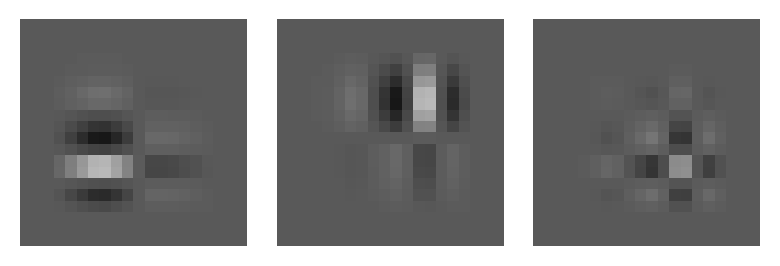

In [25]:
# plot wavelet filters
plot_filts(filt, figsize=(4,4), share_min_max=True)

## optimize filter

In [26]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)
loss_f = get_loss_f(lamL1attr=0)
trainer = Trainer(model, wt, Attributer, optimizer, loss_f, attr_methods='Saliency', device=device)

In [ ]:
trainer(train_loader, epochs=5)

Starting Training Loop...
Train Epoch: 0 [15600/25000 (100%)]	Loss: 0.000035
====> Epoch: 0 Average train loss: 1.1209
Train Epoch: 1 [9152/25000 (37%)]	Loss: 0.000000

In [ ]:
im_t = wt(im)
recon = wt.inverse(im_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - im)**2/im.size(0)))

# get 2d wavelet filters
filt = get_2dfilts(wt)

In [ ]:
# plot original and reconstruction images
plot_reconstruct(im, recon)

In [ ]:
# plot wavelet filters
plot_filts(filt, figsize=(4,4), share_min_max=True)

## test error

In [ ]:
loss_v = get_loss_f(lamL1attr=1)

# validator 
validator = Validator(model, wt, Attributer, loss_v, attr_methods='Saliency', device=device)
_, rec_loss, L1attr_loss = validator(test_loader)

# original wavelet transform
wt_o = DWT(wave='db3', mode='symmetric', J=3, init_factor=1, noise_factor=0).to(device)
validator_o = Validator(model, wt_o, Attributer, loss_v, attr_methods='Saliency', device=device)
_, rec_loss_o, L1attr_loss_o = validator_o(test_loader)

print("\n\n Original filter:Reconstruction Error={:.5f} L1attribution loss={:.5f} \n Adaptive filter:Reconstruction Error={:.5f} L1attribution loss={:.5f}"\
          .format(rec_loss_o, L1attr_loss_o, rec_loss, L1attr_loss))